The wall temperature time variation for a suddenly imposed (step response) heat flux on a semi-infinite body has the form:

$$T_w(t)= T_o + \left({4 \over \pi }\right)^{1/2} \frac{q''}{(k \rho c)^{1/2}}\sqrt{t}$$

For a series of step changes in the wall heat flux, the temperature obeys:

$$T_w(t)= T_o + \sum_{i=1}^N \left({4 \over \pi }\right)^{1/2} \frac{\Delta q_i''}{(k \rho c)^{1/2}}\sqrt{t-\tau_i}$$ 

For this problem, the $\Delta q_i''$ are the discrete jumps in the wall heat fluxes at times $\tau_i$.  Note that $\tau_N=t$.  

The form of the typical damage integral is of form:

$${d\Omega \over dt} = C \hbox{exp} \left( {-E \over RT} \right)$$

Here $\Omega$ is the damage function.    We can reasonably model damage relative to a flashover condition as follows.  For the flashover condition, the amount of time required for flashover can be estimated as the time requred for the surface to reach an ignition temperature. We can use any number of materials as our surrogate (e.g., wood as might be on the floor of the compartment).  The ignition temperatures for many different types of wood are known, and we can get the time to ignition associated with the ignition heat flux from:

$$T_{ign}= T_o + \left({4 \over \pi }\right)^{1/2} \frac{q''}{(k \rho c)^{1/2}} \sqrt{t_{ign}}$$

We can calculate the damage as:

$$\Omega = \int_{0}^{t_{ign}} C \hbox{exp} \left( {-E \over RT} \right) dt$$

Since we will normalize by this value, the true value of $C$ is unimportant. For the variable flux case, at each time, we calculate the wall temperature from:

$$T_w(t)= T_o + \sum_{i=1}^N \left({4 \over \pi }\right)^{1/2} \frac{\Delta q_i''}{(k \rho c)^{1/2}}\sqrt{t-\tau_i}$$ 

and substitute this temperature into the damage integral. The extent of damage is given as the minimum of 1 or the ratio:

$$\Omega_{q'' < q''_{FLASH}} \over \Omega_{ q''_{FLASH}}$$


$$ t_{ign} = \left(T_{ign}-T_o\right)^2\frac{\pi}{4}\frac{k \rho c}{q''^2} $$

In [1]:
import numpy as np
import contextlib

#let's test the notions underpinning this model

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

Tign = 563 #K Oak veneer plywood
krhoc = 0.413 #kJ^2/(m^4*K^2*s)
qdub = 15 #kW/m^2
To = 293 #K
E= 124.7e3 #J/mol
R = 8.314 #J/mol

tignfinder = (Tign-To)**2*(np.pi/4)*krhoc/(qdub)**2
Twinv = To+(4/(np.pi*krhoc))**(1./2.)*qdub*np.sqrt(tignfinder)

print tignfinder
print Twinv

def twbuilder(To,krhoc,qdub,start,stop,stepsize):
    """compute wall temperature profile over time for flashover condition exposure
    
    Please make sure start stop and stepsize all play nice together.
    """
    stop = stop - stop%stepsize + stepsize
    output = np.empty((int(1+(stop-start)/stepsize),2))
    for ind,i in enumerate(np.arange(start,stop+stepsize,stepsize)):
        output[ind,0] = i
        output[ind,1] = To+(4/(np.pi*krhoc))**(1./2.)*qdub*np.sqrt(i)
    return output

twflash = twbuilder(To,krhoc,15,0,tignfinder,5)
print twflash

def pyrointegral(E,R,time,walltemp):
    """calculate un-normalized total amount of pyrolysis in target"""
    pyrovalue = np.exp(-E/(R*walltemp))
#     print pyrovalue.shape
    totvalue  = np.trapz(pyrovalue,time)
    return totvalue

flashdam = pyrointegral(E,R,twflash[:,0],twflash[:,1])

print twflash[:,0].shape
damage = np.empty(len(twflash[:,0]))
# print damage

print np.arange(0,len(damage[0:len(twflash[:,0])]))

for ind in np.arange(0,len(twflash[:,0])):
#     print ind
#     print twflash[0:ind+1,0]
    damage[ind] = pyrointegral(E,R,twflash[:ind+1,0],twflash[:ind+1,1])
with printoptions(precision=3, suppress=True):
    print damage/flashdam
    



105.095699041
563.0
[[   0.          293.        ]
 [   5.          351.89199882]
 [  10.          376.28586345]
 [  15.          395.00393412]
 [  20.          410.78399764]
 [  25.          424.68651269]
 [  30.          437.25534704]
 [  35.          448.81358309]
 [  40.          459.57172689]
 [  45.          469.67599646]
 [  50.          479.23285223]
 [  55.          488.32266324]
 [  60.          497.00786823]
 [  65.          505.33812146]
 [  70.          513.35368241]
 [  75.          521.08773065]
 [  80.          528.56799528]
 [  85.          535.81793164]
 [  90.          542.85759034]
 [  95.          549.70427144]
 [ 100.          556.37302538]
 [ 105.          562.87704242]
 [ 110.          569.22795939]]
(23L,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 0.     0.     0.     0.     0.     0.     0.     0.     0.001  0.002
  0.004  0.007  0.013  0.022  0.037  0.061  0.098  0.152  0.23   0.341
  0.497  0.711  1.   ]


In [2]:
import pandas as pd
import glob
import os

len(glob.glob('./cfastrunoutput/*'))

inputfile = glob.glob(os.path.abspath('./cfastrunoutput/*'))[0]
print inputfile

pattern = r'TRGFLXT_'
raw_data = pd.read_csv(inputfile,skiprows=[1,2,3])
tfluxcols = raw_data.loc[:,raw_data.columns.str.contains(pattern)]
time = raw_data['Time']
tfluxcols.max()

name_data = pd.read_csv(inputfile,nrows=2)

tflux_colnames = name_data.loc[:,raw_data.columns.str.contains(pattern)]
# print tflux_colnames
targtrans = {a:b for (a,b) in zip(tflux_colnames.columns,tflux_colnames.iloc[1,:])}
print targtrans
timestep = time[1]-time[0]
print timestep

C:\Users\Austin\Dropbox\CommRiskIAFF\CFASTprocessing\CFASTdamagemodel\cfastrunoutput\House_1423_3_2-bedrm1-BedroomA-D-0_w.csv
{'TRGFLXT_3': 'livingroomfloortarget', 'TRGFLXT_2': 'bedrm2floortarget', 'TRGFLXT_1': 'bedrm1floortarget', 'TRGFLXT_7': 'kitchenfloortarget', 'TRGFLXT_6': 'diningroomfloortarget', 'TRGFLXT_5': 'mbedrmfloortarget', 'TRGFLXT_4': 'hall2floortarget', 'TRGFLXT_9': 'hall1floortarget', 'TRGFLXT_8': 'stairsfloortarget'}
10.0


In [3]:
def Twallsolver(times,heatfluxes,initialtemp,krhoc):
    """Build and return wall temperature values for a given input of heat flux values
    
       Note: returns the wall temperature for each given time step using a Duhamel 1-D semi-infinite solid approximation
       heatfluxes::numpy array
       initialtemp::float
       times::numpy array
    """
    Nsteps = len(times)
    timestep = times[1]-times[0] #this fails for irregular timesteps, we expect timestep to be constant
    Nvec = np.asarray([Nsteps-i for i in np.arange(Nsteps)])
    delq = np.append(heatfluxes,0)
    delq = delq-np.roll(delq,1)
    delq = np.delete(delq,len(delq)-1)
    output = np.empty(Nsteps)
    for ind in np.arange(len(delq)):
        output[ind] = To+(4/(np.pi*krhoc))**(1./2.)*timestep*np.inner(delq[0:ind+1],np.sqrt(Nvec[Nsteps-ind-1:Nsteps]))
    return output

def damagecurvecalc(time,Twall,E,R,flashoverdamage):
    """Calculate the relative damage curve for a given target
    
        time - array of times
        Twall - array of target surface temperatures
        E - Arrhenius-style activation energy of target in #J/mol (see Agrawal 1985 "On the use of the arrhenius equation
        to describe cellulose and wood pyrolysis
        R - universal gas constant #J/mol
        flashoverdamage - total pyrolysis computed for wood subjected to flashover heat flux until ignition)
    """
    if len(time) != len(Twall):
        raise Exception("Lengths of time and Twall vectors unequal")
    damageoutput = np.empty(len(Twall))
    for ind in np.arange(len(damageoutput)):
        damageoutput[ind] = pyrointegral(E,R,time[:ind+1],Twall[:ind+1])
    damagecurve = np.empty(len(damageoutput))
    for ind in np.arange(len(damagecurve)):
        damagecurve[ind] = min(1,damageoutput[ind]/flashoverdamage)
    return damagecurve

# output = Twallsolver(time,tfluxcols['TRGFLXT_1'],To,krhoc)
# damagecurve = damagecurvecalc(time,output,E,R,flashdam)

In [4]:
import cfastExtract as ce

def strucdamagecalc(inputfile,modelfiledirectory,flashoverdamage,krhoc=0.413,E=124.7e3,R=8.314,initialtemp=293):
    """calculates a structural damage curve based on a model input file
    
    inputfile::cfast *_w.csv file, preferably following a hierarchical naming convention
               with base model name in the first position
    modelfile:: corresponding directory where base model files are stored.
    flashoverdamage:: value of integral of pyrolysis reaction over target wood of choice when exposed 
                  to designated flashover heat flux
    initialtemp::initial temperature of target (K)
    krhoc:: value of thermal conductivity k, density rho, and specific heat capacity c (kJ^2 m^-4 K^-2 s^-1)
    E :: activation energy of wood pyrolysis arrhenius fit (J/mol)
    R :: universal gas constant (J/mol)

    output: numpy array containing a time column and a total damage column.
    """
    #Room size calcs
    infile = os.path.basename(inputfile).split('.')[0]
    room = infile.split('-')[1]
    basemodel = infile.split('-')[0]+'.in'
    test = ce.cfastExtract(os.path.abspath('/'.join((modelfiledirectory,basemodel))))
    roomsizes = {a[0]:float(a[1])*float(a[2]) for a in test.rooms.values()}
    roomtot = sum(roomsizes.values())
    #damage calcs
    pattern = r'TRGFLXT_'
    raw_data = pd.read_csv(inputfile,skiprows=[1,2,3])
    tfluxcols = raw_data.loc[:,raw_data.columns.str.contains(pattern)]
    time = raw_data['Time'].as_matrix()
    name_data = pd.read_csv(inputfile,nrows=2)
    tflux_colnames = name_data.loc[:,raw_data.columns.str.contains(pattern)]
    targtrans = {a:b.replace("floortarget","") for (a,b) in zip(tflux_colnames.columns,tflux_colnames.iloc[1,:])}
    damageroomcurves = tfluxcols.copy()
    for name, i in tfluxcols.iteritems():
        damageroomcurves[name] = damagecurvecalc(time,Twallsolver(time,i,initialtemp,krhoc),E,R,flashdam)*roomsizes[targtrans[name]]
    alldamage = damageroomcurves.sum(axis=1)
    #calculate percentage of damage corresponding to room of origin area + 0.01 meters
    roomorigdam = (roomsizes[room]+0.01) / sum(roomsizes.values())
#     if np.any(alldamage > roomsizes[room]+0.01):
#         print 5
    totdamage = alldamage / sum(roomsizes.values())
    return (roomorigdam, np.column_stack((time,totdamage)))


modelfiledirectory = os.path.abspath('../homeplans/CFASTmodels/')
totaldamage = strucdamagecalc(inputfile,modelfiledirectory,flashdam)
print totaldamage

# #Room size calcs
# modelfiledirectory = os.path.abspath('../homeplans/CFASTmodels/')
# infile = os.path.basename(inputfile).split('.')[0]
# room = infile.split('-')[1]
# basemodel = infile.split('-')[0]+'.in'
# test = ce.cfastExtract(os.path.abspath('/'.join((modelfiledirectory,basemodel))))
# roomsizes = {a[0]:float(a[1])*float(a[2]) for a in test.rooms.values()}
# roomtot = sum(roomsizes.values())

# #damage calcs
# pattern = r'TRGFLXT_'
# raw_data = pd.read_csv(inputfile,skiprows=[1,2,3])
# tfluxcols = raw_data.loc[:,raw_data.columns.str.contains(pattern)]
# time = raw_data['Time']
# name_data = pd.read_csv(inputfile,nrows=2)
# tflux_colnames = name_data.loc[:,raw_data.columns.str.contains(pattern)]
# targtrans = {a:b.replace("floortarget","") for (a,b) in zip(tflux_colnames.columns,tflux_colnames.iloc[1,:])}
# damageroomcurves = tfluxcols.copy()
# for name, i in tfluxcols.iteritems():
#     damageroomcurves[name] = damagecurvecalc(time,Twallsolver(time,i,To,krhoc),E,R,flashdam)*roomsizes[targtrans[name]]
# alldamage = damageroomcurves.sum(axis=1)
# if np.any(alldamage > roomsizes[room]+0.01):
#     print 5
# totaldamage = alldamage / sum(roomsizes.values())
# print totaldamage
# print roomsizes
# print room
# print basemodel
# print infile
# print targtrans

(0.10056390515380793, array([[  0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+01,   1.08311678e-11],
       [  2.00000000e+01,   2.17133781e-11],
       [  3.00000000e+01,   3.26851288e-11],
       [  4.00000000e+01,   4.38016461e-11],
       [  5.00000000e+01,   5.51416784e-11],
       [  6.00000000e+01,   6.68142352e-11],
       [  7.00000000e+01,   7.89537127e-11],
       [  8.00000000e+01,   9.17266731e-11],
       [  9.00000000e+01,   1.05362275e-10],
       [  1.00000000e+02,   1.20185125e-10],
       [  1.10000000e+02,   1.36662070e-10],
       [  1.20000000e+02,   1.55481454e-10],
       [  1.30000000e+02,   1.77668348e-10],
       [  1.40000000e+02,   2.04777094e-10],
       [  1.50000000e+02,   2.39240092e-10],
       [  1.60000000e+02,   2.84939507e-10],
       [  1.70000000e+02,   3.48124319e-10],
       [  1.80000000e+02,   4.40559933e-10],
       [  1.90000000e+02,   5.85051340e-10],
       [  2.00000000e+02,   8.25004442e-10],
       [  2.10000000e+02,   1.247

In [5]:

inputfilelist = glob.glob(os.path.abspath('../../../../My Documents/cfastrunoutput/*'))
# print inputfilelist[0:2]
# print len(inputfilelist)

#construct the pandas dataframe housing the data
d = []
i = 0
for filename in inputfilelist:
#     print filename
    infile = os.path.basename(filename).split('.')[0]
#     print infile
    parsefile = infile.split('-')
    roomorigdamage, damagetot = strucdamagecalc(filename,modelfiledirectory,flashdam)
    d.append({'modelname':parsefile[0],'roomname':parsefile[1],'roomtype':parsefile[2],'itemname':parsefile[3],
              'samplenumber':parsefile[4].split('_')[0], 'damagecurve':damagetot, 'roomorigdam':roomorigdamage})
    i+=1
    
# print len(inputfilelist[0])
print i
# print d


5167


In [6]:
damageoutput = pd.DataFrame(d)

print damageoutput.roomorigdam.max()

0.276229759448


In [7]:
damageoutput.to_pickle('damagecurveoutput.p')

In [8]:
import holoviews as hv
hv.notebook_extension('matplotlib')


:Layout
   .Curve.I  :Curve   [Time(s)]   (Damage(?))
   .Curve.II :Curve   [Time(s)]   (Temp (K))
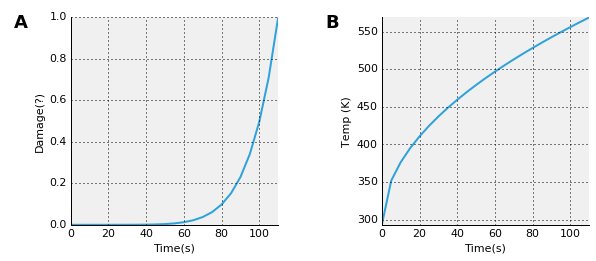

In [9]:
%%opts Layout [normalize=False]
test = hv.Curve((twflash[:,0],damage/flashdam),kdims=['Time(s)'],vdims=['Damage(?)'])
test + hv.Curve((twflash[:,0],twflash[:,1]),kdims=['Time(s)'],vdims=['Temp (K)'])


In [10]:
%%opts Layout [normalize=False]
# hv.help(hv.Curve((time,output)))
hv.Curve(totaldamage,extents=(0,0,500,1))#+hv.Curve((time,output))+hv.Curve((time,damagecurve),extents=(0,0,500,1))

TypeError: len() of unsized object

:Curve   [x]   (y)